In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib notebook

class PCA_class:

    def __init__(self):
        # components variable is to keep eigen vectors
        self.components = None
        self.mean = None
        self.eigenvalues = None

    def fit(self, X, n_components = None):
        # n_components variable is number of primary principal components to keep
        if n_components == None:
            n_components = np.shape(X)[1]
        else:
            n_components = n_components
            
        # Find mean
        self.mean = np.mean(X, axis = 0)

        # Mean is subtracted from data in formula
        # so I subtract mean here
        X -= self.mean

        # Calculating covariance matrix
        cov = np.cov(X.T)

        # Getting eigenvalues and eigenvectors
        self.eigenvalues, eigenvectors = np.linalg.eig(cov)
        self.eigenvalues = self.eigenvalues.real
        eigenvectors = eigenvectors.real
        # linalg.eig method return eigenvectors in columns
        # such as one eigenvectors in one column
        eigenvectors = eigenvectors.T

        # Sorting indices in decreasing order
        sorted_indices = np.argsort(self.eigenvalues)[::-1]

        # Sorting eigenvalues and eigenvectors according indices in decreasing order
        self.eigenvalues = self.eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[sorted_indices]

        # Keep first N components from the beginning to number of components
        self.components = eigenvectors[0:n_components]

    # This function will transform the data, it's projection.
    def transform(self, data):
        # I subtract mean from data as it's the first step of transformation.
        # I take transpose of components because in order to perform dot product
        # one dimension of each sides which are applied in dot product must be the 
        # same. After transpose, number of components of data and number of samples will be
        # the same
        # Source of explanation: https://stackoverflow.com/questions/32750915/pca-inverse-transform-manually
        data -= self.mean
        return np.dot(data, self.components.T)
    
    # I decide optimum number of components with the help of this function,
    # idea on this link helped me: 
    # https://www.quora.com/What-is-the-best-way-to-choose-the-number-of-components-in-PCA-during-dimensionality-reduction
    def plot(self):
        plt.figure(figsize = (5,4))
        # explained_variance_ is the actual eigen values and explained_variance_ratio 
        # is the percentage of the variance.
        explained_variance = self.eigenvalues
        # By observing the curve, I will decide the optimum number of components
        plt.plot(np.cumsum(explained_variance), marker = 'o', linestyle = '--')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance Ratio')
        plt.show()

In [14]:
# Decision tree with one split is used as weak classifier
class DT_one_split:
    def __init__(self):
        self.polarity = 1
        self.index_of_feature = None
        # Performance of classifier
        self.alpha_val = None
        # Split threshold for decision stump
        self.split_threshold = None

    def predict(self, X):
        n_samples = X.shape[0]
        # I keep all the samples but only this feature index
        X_vec = X[:, self.index_of_feature]
        
        preds = np.ones(n_samples)
        
        # If polarity is 1 then all predictions that are smaller where the 
        # feature vector is smaller than threshold then
        # these predictions are -1.
        # If polarity is not 1 then all predictions that are greater where the 
        # feature vector is greater than threshold then
        # these predictions are -1
        if self.polarity == 1:
            preds[X_vec < self.split_threshold] = -1
        else:
            preds[X_vec > self.split_threshold] = -1
        return preds


class AdaBoost_m:
    def __init__(self, num_of_classifiers=5):
        # number of classifiers
        self.num_of_classifiers = num_of_classifiers
        self.classifier_list = []

    def fit(self, X, y):
        num_samples, num_features = X.shape

        # init weights to 1/N
        w = np.full(num_samples, (1 / num_samples))
        
        # List to store all classifiers
        self.classifier_list = []

        # Iterate through classifiers
        for _ in range(self.num_of_classifiers):
            classi = DT_one_split()
            # I want to find the best split feature value and best split threshold
            # where this error is minimum
            error_min = float("inf")
           
            # Iterate over features and thresholds
            # in order to find best threshold and feature
            for ind_feature in range(num_features):
                X_vec = X[:, ind_feature]
                # I get unique values and they are thresholds
                thresholds = np.unique(X_vec)
                
                for threshold in thresholds:
                    p = 1
                    preds = np.ones(num_samples)
                    preds[X_vec < threshold] = -1
                    
                    # Error = sum of weights over misclassified samples
                    preds = preds.reshape(len(preds),1)
                    w = w.reshape(len(w),1)
                    misclassified = w[y != preds]
                    error = sum(misclassified)

                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # Keeping the best configuration
                    if error < error_min:
                        classi.split_threshold = threshold
                        classi.polarity = p
                        classi.index_of_feature = ind_feature
                        error_min = error
            
            # calculate alpha
            # EPS is used in order to prevent division by zero, EPS is a very small value.
            EPS = 1e-10
            # Formula to find alpha is applied below.
            classi.alpha_val = 0.5 * np.log((1.0 - error_min + EPS) / (error_min + EPS))
            
            # Calculate predictions and update weights
            preds = classi.predict(X)
            preds = preds.reshape(len(preds),1)
            
            # Here I update weights
            w *= np.exp(-classi.alpha_val * y * preds)
            
            w /= np.sum(w)
            
            # Save classifier
            self.classifier_list.append(classi)

    def predict(self, X):
        classi_preds = [classi.alpha_val * classi.predict(X) for classi in self.classifier_list]
        y_pred = np.sum(classi_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred

## DROPPING HIGHLY CORRELATED FEATURES (WHERE CORRELATION IS > 0.95)

In [3]:
df = pd.read_csv("/home/oem/Desktop/pd_speech_features.csv", sep = ",")

# I drop "id" feature since every value of it is unique and it does not contribute
# to classification
del df['id']

def drop_highly_correlated(df):
    # I will have the elements as the absolute value of correlation between the features
    cor_matrix = df.corr().abs()
    # I take upper triangle because upper and lower triangle's are the same
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
    # I am selecting the columns which are having absolute correlation greater than 0.95 
    # and creating a list of those columns
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
    print()
    print("Number of features in df BEFORE drop: {}".format(len(df.columns)))
    print() 
    print("Number of features that will be dropped: {}".format(len(to_drop)))
    print()
    df = df.drop(to_drop, axis=1)
    print("Number of features in df AFTER drop: {}".format(len(df.columns)))
    print()
    print(df.head())
    return df

df = drop_highly_correlated(df)


Number of features in df BEFORE drop: 754

Number of features that will be dropped: 241

Number of features in df AFTER drop: 513

   gender      PPE      DFA     RPDE  numPulses  meanPeriodPulses  \
0       1  0.85247  0.71826  0.57227        240          0.008064   
1       1  0.76686  0.69481  0.53966        234          0.008258   
2       1  0.85083  0.67604  0.58982        232          0.008340   
3       0  0.41121  0.79672  0.59257        178          0.010858   
4       0  0.32790  0.79782  0.53028        236          0.008162   

   stdDevPeriodPulses  locPctJitter  locShimmer  apq11Shimmer  ...  \
0            0.000087       0.00218     0.05883       0.04828  ...   
1            0.000073       0.00195     0.05516       0.06195  ...   
2            0.000060       0.00176     0.09902       0.07772  ...   
3            0.000183       0.00419     0.05451       0.04462  ...   
4            0.002669       0.00535     0.05610       0.05278  ...   

   tqwt_kurtosisValue_dec_28  tq

### Since number of features is not appropriate for visualization, I couldn't visualize.

### It is time to check if class feature is balanced or not, if it's balanced then we can get good results for classification.

<IPython.core.display.Javascript object>


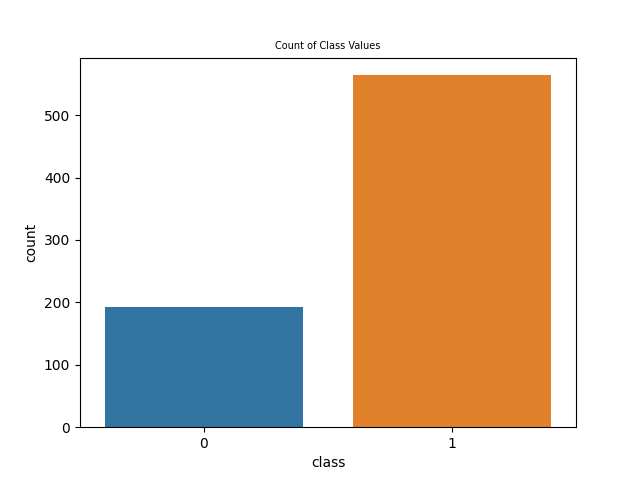

Text(0.5, 1.0, 'Count of Class Values')

In [4]:
sns.countplot(df['class'])
plt.title('Count of Class Values', size = 7)

### There is difference but we can still get good results.

#

### There is no categorical value in dataset  therefore no need to turn them into numerical values.

In [5]:
def normalization_and_preprocess(df):
    
    # Check if any nan value in dataset
    print("\nIs there any nan value in dataset:",df.isna().values.any())
    print("\n")
    
    # There are values such as 0.000000135 and 4451980.807 in the dataset,
    # there is a huge difference between such values 
    # therefore their affect on classficiation result will
    # be very different so I am going to normalize values
    # but firstly I will take "gender" and "class" features
    # to another dataframes because their values are binary
    # values, they shouldn't be normalized.
    
    df_class = pd.DataFrame(df, columns = ['class'])
    df_gender = pd.DataFrame(df, columns = ['gender'])
    
    # I drop gender and class features from main df
    del df['gender']
    del df['class']
    
    # Normalization
    scaler = preprocessing.MinMaxScaler()
    names = df.columns
    df_n = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(df_n, columns = names)
    df_train = pd.concat([scaled_df, df_gender], axis = 1)
    

    return df_train, df_class

In [6]:
X, Y = normalization_and_preprocess(df)


Is there any nan value in dataset: False




# Outlier Detection with LOF

In [7]:
columns = X.columns.tolist()

# ‘auto’ will attempt to decide the most appropriate algorithm
# to compute the nearest neighbors based on the values passed to fit method.
lof = LocalOutlierFactor(algorithm = 'auto')
pred_values = lof.fit_predict(X)
scores_of_X = lof.negative_outlier_factor_

# I create dataframe to keep outlier scores and then to get indexes of them
df_outlier = pd.DataFrame()
df_outlier['scores'] = scores_of_X

<IPython.core.display.Javascript object>


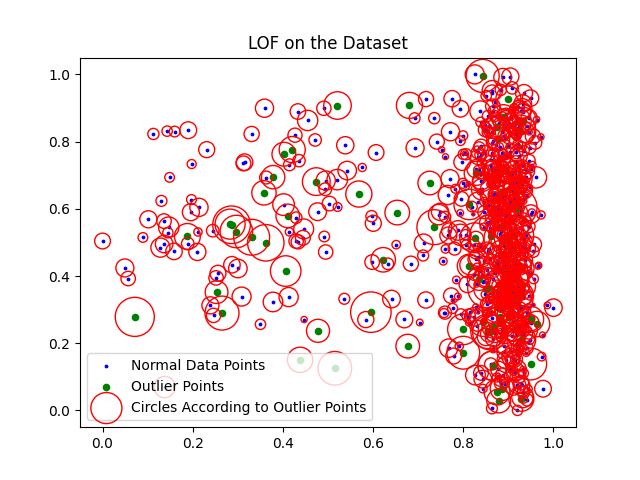

In [8]:
# I selected threshold as -1.25 and I get indexes of outlier
# values which are having score greater than 1.25.
index_of_outliers = df_outlier[df_outlier['scores'] < -1.25].index.tolist()

plt.figure()
plt.title("LOF on the Dataset")
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], color="b", s=3.0, label="Normal Data Points")
plt.scatter(X.iloc[index_of_outliers, 0], X.iloc[index_of_outliers, 1], color="g", s=20.0, label="Outlier Points")

# Normalizing in order to see plot of outliers
radius_of_circles = (scores_of_X.max() - scores_of_X) / (scores_of_X.max() - scores_of_X.min())
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=1000 * radius_of_circles, edgecolors="r", facecolors="none",
    label="Circles According to Outlier Points",
)
plt.legend()
plt.show()

### Now I drop outliers from my dataset

In [9]:
X = X.drop(index_of_outliers)
Y = Y.drop(index_of_outliers).values

### Here I plot the curve according to Cumulative Sum of Explained Variance(Eigenvalues) to determine optimum number of components in order to keep %90 of variation.

<IPython.core.display.Javascript object>


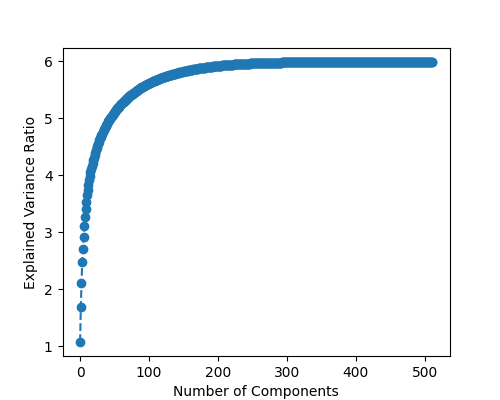

In [10]:
def opt_n_components(X):
    pca_to_plot = PCA_class()
    pca_to_plot.fit(X)
    pca_to_plot.plot()
    
opt_n_components(X)

### As shown in the interactive curve above, the first 25 components describe about 80% of the variance, whereas we'll need roughly 185 components to describe close to 100% of the variance. Since the 2D projection loses a lot of information, we'll need roughly 60 components to keep 90% of the variation.

### I apply PCA  on the data with n_components as 60.

In [11]:
def pca_(X):
    pca = PCA_class()
    pca.fit(X,60)
    train = pca.transform(X)
    print("Shape of train data after PCA: ", X.shape)
    print("Shape of train data after PCA: ", train.shape)
    return train

### Here I split my dataset into 4 parts: x_train, x_test, y_train, y_test

In [12]:
train_data = pca_(X)
labels = Y

X_train, X_test, y_train, y_test = train_test_split(
        train_data, labels, test_size=0.2, random_state=42)

Shape of train data after PCA:  (674, 512)
Shape of train data after PCA:  (674, 60)


In [15]:
ada_classifier = AdaBoost_m(num_of_classifiers=5)
ada_classifier.fit(X_train, y_train)
y_pred = ada_classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy of My Adaboost Classifier:", acc)

#####

clf = AdaBoostClassifier(n_estimators=5)
clf.fit(X_train, y_train)
y_pred_ada = clf.predict(X_test)

acc_ada = accuracy_score(y_test, y_pred_ada)
print("Accuracy of Built-in Adaboost Classifier:", acc_ada)

#####

svc = SVC()
svc.fit(X_train, y_train)
y_pred_svm = svc.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy of Built-in SVM Classifier:", acc_svm)

#####

mlp = MLPClassifier()
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
print("Accuracy of Built-in MLP Classifier:", acc_mlp)

#####

random_forest =  RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred_random_forest = random_forest.predict(X_test)

acc_random_forest = accuracy_score(y_test, y_pred_random_forest)
print("Accuracy of Built-in Random Forest Classifier:", acc_random_forest)

Accuracy of My Adaboost Classifier: 0.762962962962963
Accuracy of Built-in Adaboost Classifier: 0.8222222222222222
Accuracy of Built-in SVM Classifier: 0.8592592592592593
Accuracy of Built-in MLP Classifier: 0.8518518518518519
Accuracy of Built-in Random Forest Classifier: 0.8222222222222222
